## Trabajo Práctico Final
<br/>

## Curso de Especialización en Inteligencia Artificial
## Análisis de Series de Tiempo
<br/>

### Autor: Maximiliano Torti
### Fecha: 27/11/21
<br/>

1- Graficar una serie a partir de un dataset relevante. Explicar observaciones.

2- Descomponer una serie de tiempo usando el modelo aditivo y el modelo multiplicativo.

3- Aplicar los modelos vistos en clase:
- para la tendencia usar cuadrados mínimos y expresar los coeficientes. Sacar conclusiones acerca de la validez del modelo.
- componente cíclica: usar análisis espectral y hallar las frecuencias principales.
- para la componente estacional usar ARIMA.
- para la componente de error obtener R_k, C_k.


4- Predicciones:
- realizar predicciones usando (S)ARIMA
- realizar predicciones usando redes neuronales LSTM
- extraer conclusiones

--------------------------------------------------------------------------------------------------------------------------------
## Carga de librerías

In [41]:
# Importamos librerias
import pickle as pkl
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf
from scipy.optimize import curve_fit
from scipy import signal

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

--------------------------------------------------------------------------------------------------------------------------------
## Punto 1

In [2]:
# Carga de datos
path = './data/'

with open(path+ 'df_data_structured.pkl','rb') as file:
    df_x=pkl.load(file)

### Introducción
Este dataset fue creado y donado (públicamente) por ZeMA GmbH, un centro de investigación y desarrollo en mecatrónica y tecnologías de automatización ubicado en Alemania.

El dataset fue recopilado realizando ciclos de trabajo (se explicaran con detalle) sucesivos de 60 segundos de duración sobre un banco de pruebas de un circuito, midiendo las variables típicas de un procesos de este tipo (presiones, temperaturas, flujos) a la vez que se "variaba" la condición de sus componentes críticos. El objetivo de estos experimoentos era estudiar si es posible predecir, en base a las series de tiempo de las señales básicas, el estado de vida útil de los componentes críticos.

El banco consiste en un circuito primario de trabajo (donde circula el fluido por la máquina objetivo a lubricar o refrigerar), y un circuito secundario de enfriamiento para mantener el fluido en cierta temperatura. Los circuitos estan relacionados por un tanque común.
En la siguiente figura se puede observar el esquema de componentes.

<br />

<div style="clear: both">
<img src="img/System.png" style="width: 1000px;float:left">
</div>

<div style="clear: both">
</div>

<br />

El dataset posee la medición de 2205 ciclos de 17 señales. Cada ciclo posee 60, 600 o 6000 puntos dependiendo de la señal.

Las señales de proceso medidas son:
- 6 presiones de diferentes zonas. PS1-PS6
- Potencia de bomba principal. EPS1
- Flujo de circuito primario y secundario. FS1 y FS2
- 4 temperaturas de diferentes zonas. TS1 - TS4
- Vibraciones de la bomba principal. VS1
- Eficiencia de enfriamiento. CE
- Potencia de enfriamiento. CP
- Factor de eficiencia. SE

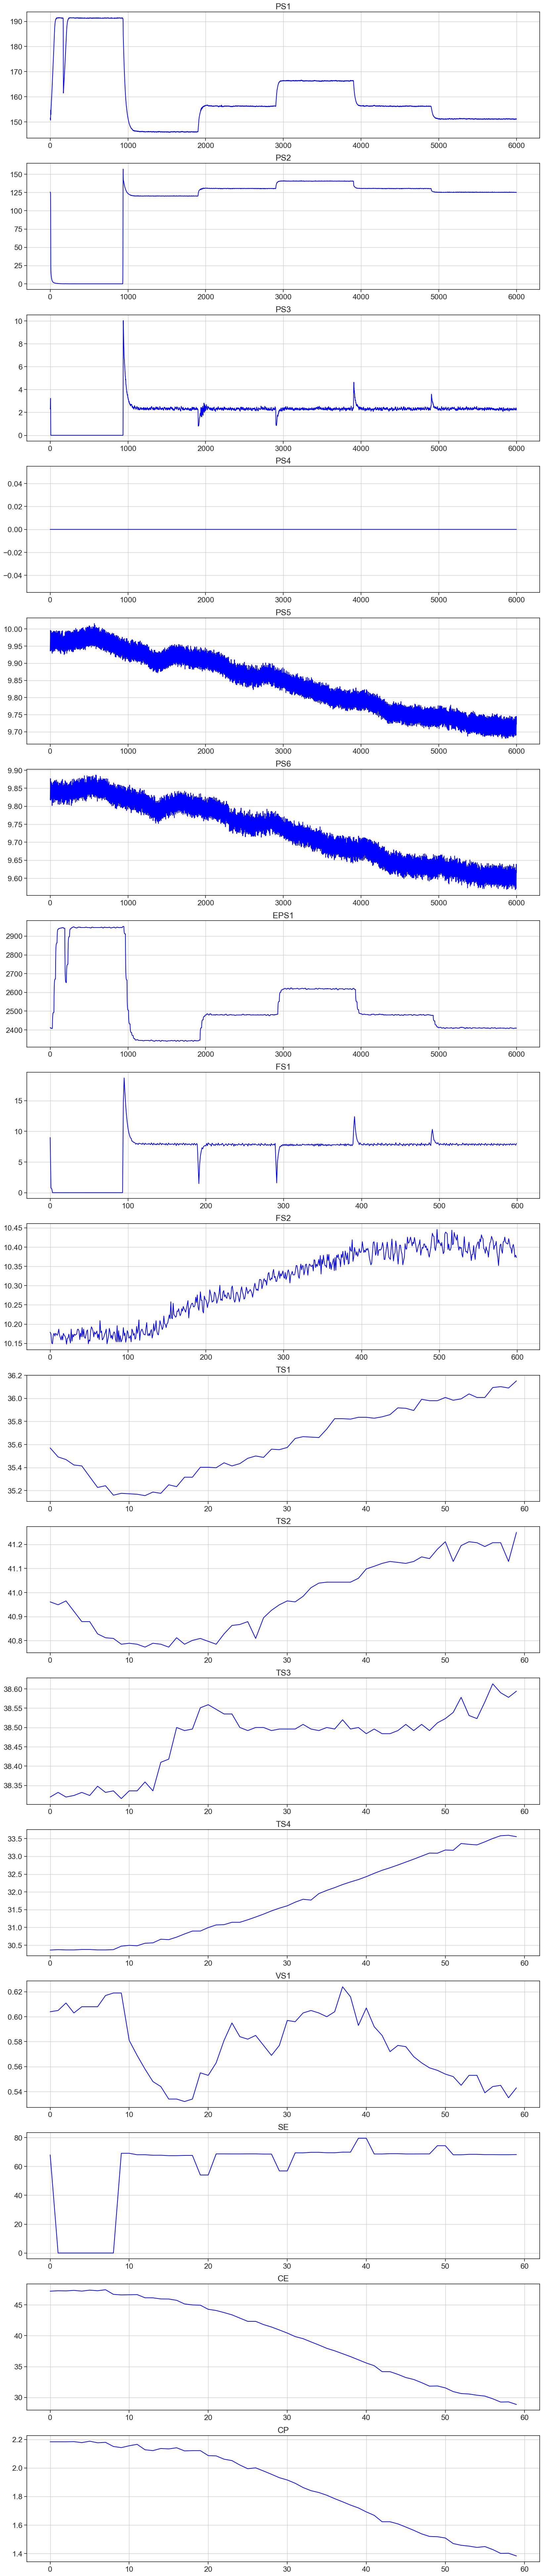

In [3]:
# Grafico de señales en un solo cicloa
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal_aux= df_x[col][0,:]
    axs[i].plot(signal_aux[~np.isnan(signal_aux)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid(True)
plt.show()

**Breve explicación de las gráficas**

El ciclo de trabajo comienza en el instante 0 donde se aplica energía a la bomba MP1 (EPS1) para inyectar fluido por el circuito primario . Al estar la valvula V10 cerrada, se eleva la presión PS1 (previa a la válvula) sin elevar la presión PS2. Una vez alcanzada la presión de trabajo(en el instante 1000 aproximadamente), se abre la válvula V10 lo cual eleva la presión PS2 y disminuye PS1. A partir de este punto el fluido pasa por la máquina destino, intentando mantener el flujo (FS1) y la presión PS3 aproximadamente constante.  

Una vez que abre la válvula V10, el aceite comienza a calentarse (TS1 y TS2). En estas condiciones, el circuito secundario toma liquido del tanque y lo circula por un enfriador que desciende la temperatura de TS3 a TS4.

### Análisis

Se observa que estamos antes una serie de tiempo multivariada, donde el proceso depende de múltiples variables como presiones, temperaturas, potencias, etc. Dada la complejidad y el tamaño del dataset, este trabajo se centrará en el estudio de solamente de la variable PS1 (aunque el mismo análisis se podría extender al resto), y acotaremos a los primeros 100 ciclos para que las potencias de cómputo disponibles sean suficientes. Comenzamos graficando PS1 como un trend completo y como ciclos separados superpuestos:

In [4]:
serie = df_x['PS1'][:100,:]
x_serie = np.arange(0,serie.shape[1]*0.01,0.01, dtype=np.float64)
serie_1d = serie.reshape(-1,1)[:,0]
x_serie_1d= np.arange(0,serie_1d.size*0.01,0.01, dtype=np.float64)

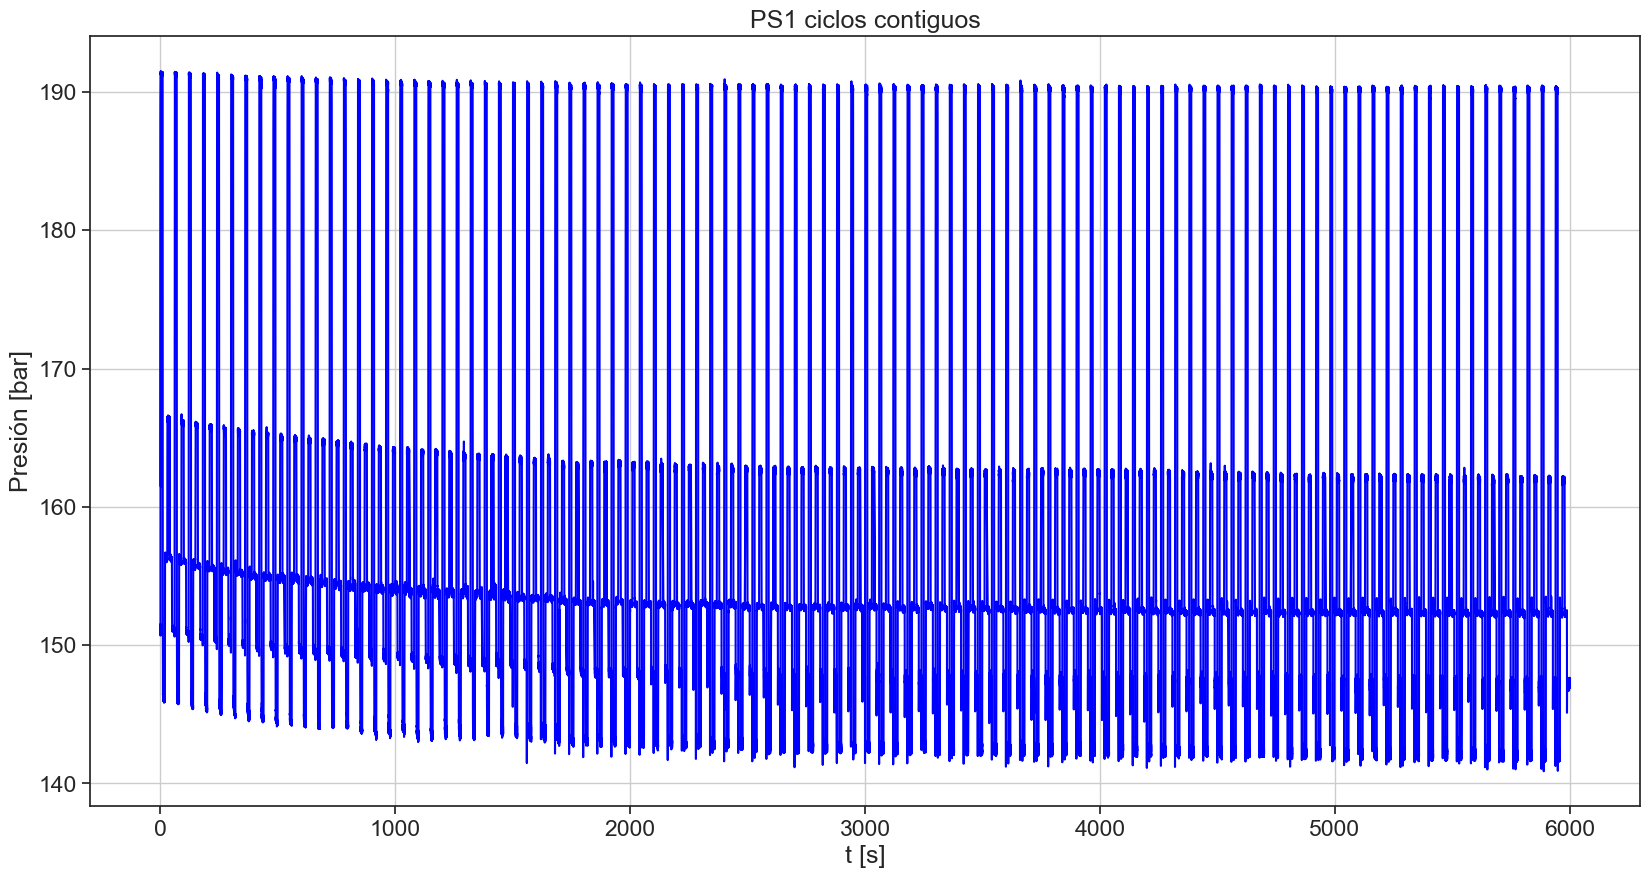

In [5]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d,serie_1d,color='blue')
ax.set_title("PS1 ciclos contiguos")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

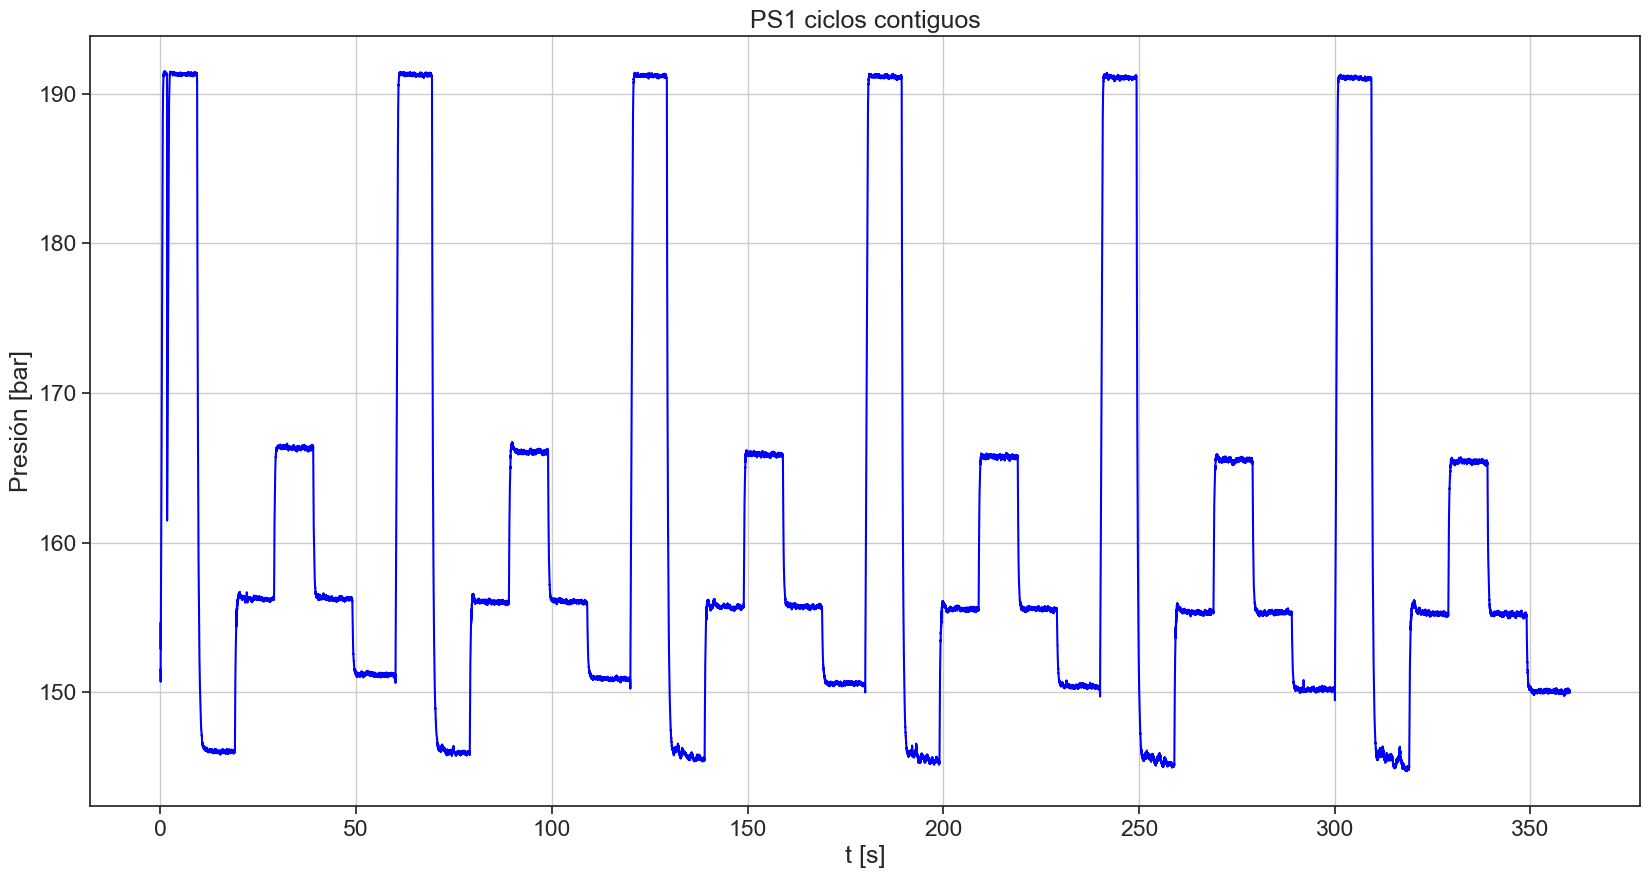

In [6]:
# Vista con mayor detalle
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d[0:36000],serie_1d[0:36000],color='blue')
ax.set_title("PS1 ciclos contiguos")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

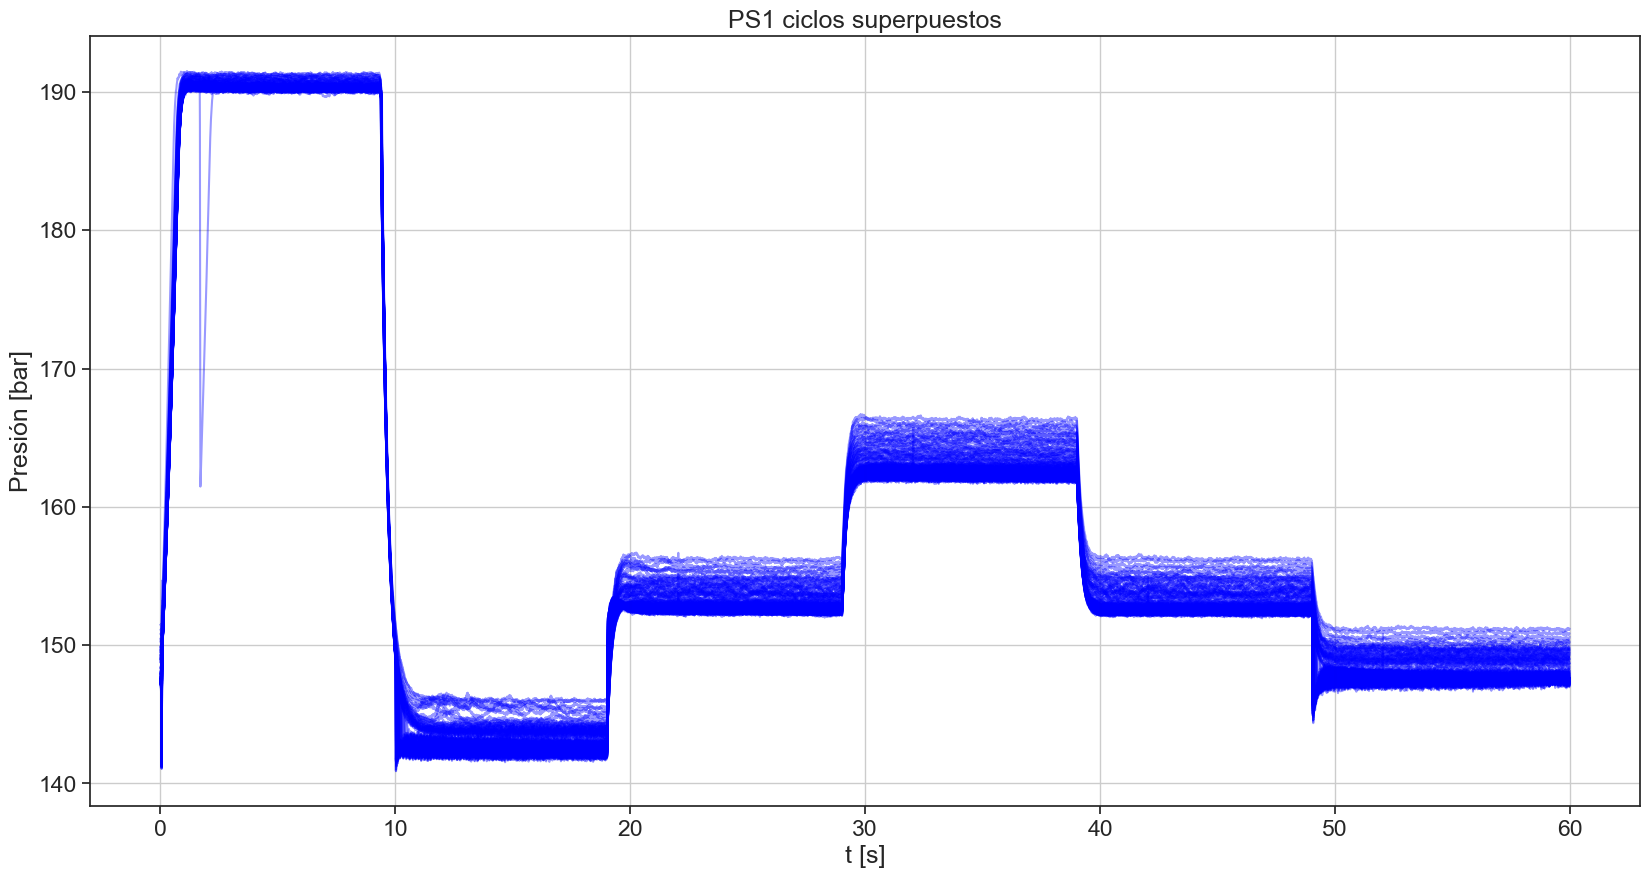

In [7]:
fig, ax = plt.subplots(1,figsize=(20, 10))
for i in range(serie.shape[0]):
    ax.plot(x_serie,serie[i],color='blue',label=None, alpha = 0.4)
ax.set_title("PS1 ciclos superpuestos")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

Tal como se mencionó anteriormente, la serie comienza en una presión alrededor de los 140 bar, luego se eleva a 190 bar y se mantiene por unos segundos en ese valor hasta el instante 10, donde se abre la válvula de circulación genrando una caída de presión abrupta a 145 bar. A partir de este momento, la presión crece a 155 bar y 165 bar y luego decrece a 155 bar y 150 bar escalonadamente cada 10 segundos aproximadamente. Este crecimiento y decrecimiento son generados para poder mantener un flujo constante de aceite sobre el circuito a medida que el proceso evoluciona. 

Desde un punto de vista estadístico, la serie es marcadamente no estacionaria. Ya a simple vista se observa que la media no es constante en el tiempo. Podemos decir que tiene una fuerte componente estacional con un ciclo de 60 segundos (6000 puntos), y de la primer gráfica también se aprecia una posible tendencia leve, ya que la presión mínima y máxima de cada ciclo paracen decrecer conforme pasa el tiempo. 

Por último se identifican algunos puntos outliers en los primeros segundos.

--------------------------------------------------------------------------------------------------------------------------------
## Punto 2 y 3

### Modelo aditivo

Se intentará descomponer la serie de tiempo en un modelo estacional aditivo, dado por:

Yt = Tt + St + Ct + et

Con:
- Tt: tendencia.
- St: variación estacional.
- Ct: Componente cíclico.
- et: Componente aleatoria.

Empezando con la tendencia, se presupone que la tendencia tiene una forma cuadrática Tt=a*t+b. Se estimará esta tendencia con cuadrados mínimos.

Se demuestra que para tendencia cuadrática, la solución por CM resulta:

In [8]:
def objective(t,a,b,c):
    return a*t+b*t**2+c 

popt, _ = curve_fit(objective, x_serie_1d, serie_1d)
a,b,c = popt

In [9]:
a

-0.0013258997235471826

In [10]:
b

1.3962914000988436e-07

In [11]:
c

160.25124404527307

In [12]:
y_line = objective(x_serie_1d,a,b,c)

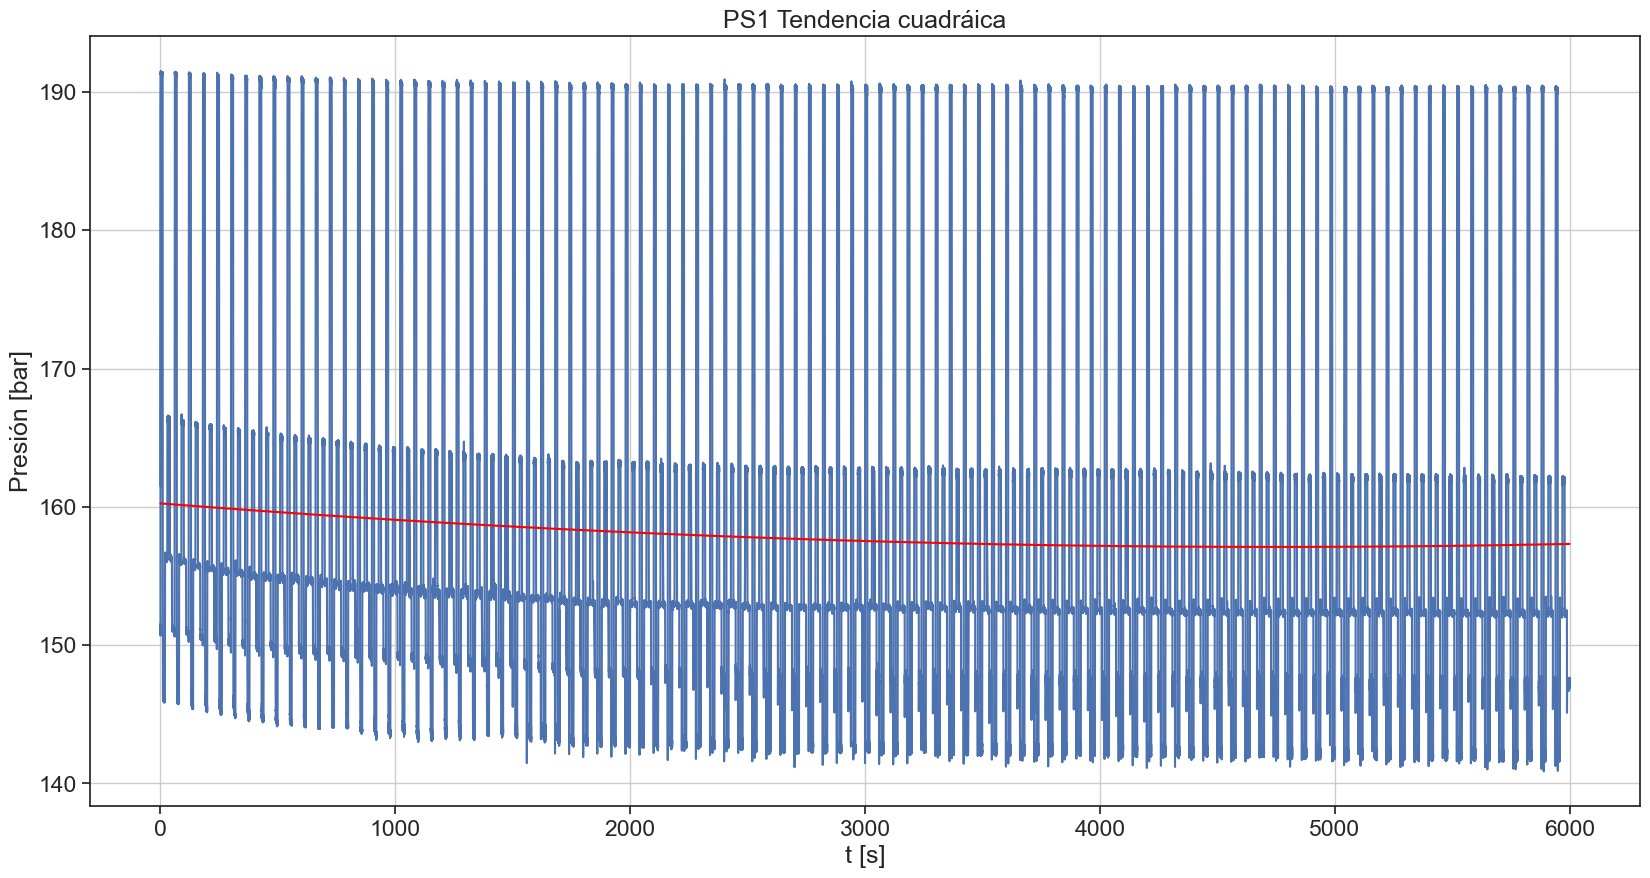

In [13]:
# Grafico de estimación de tendencia. Azul valores reales, rojo valores modelados
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d, serie_1d)
ax.plot(x_serie_1d,y_line, color = 'red')
ax.set_title("PS1 Tendencia cuadráica")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

Se observa que el modelo sugerido para Tt parece acompañar aproximadamente la tendencia de la serie. Para comprobar la validez, se analiza la diferencia Yt-Tt

In [14]:
Tt = y_line

Media :  2842.0459030046227
Varianza :  3002929.612845464


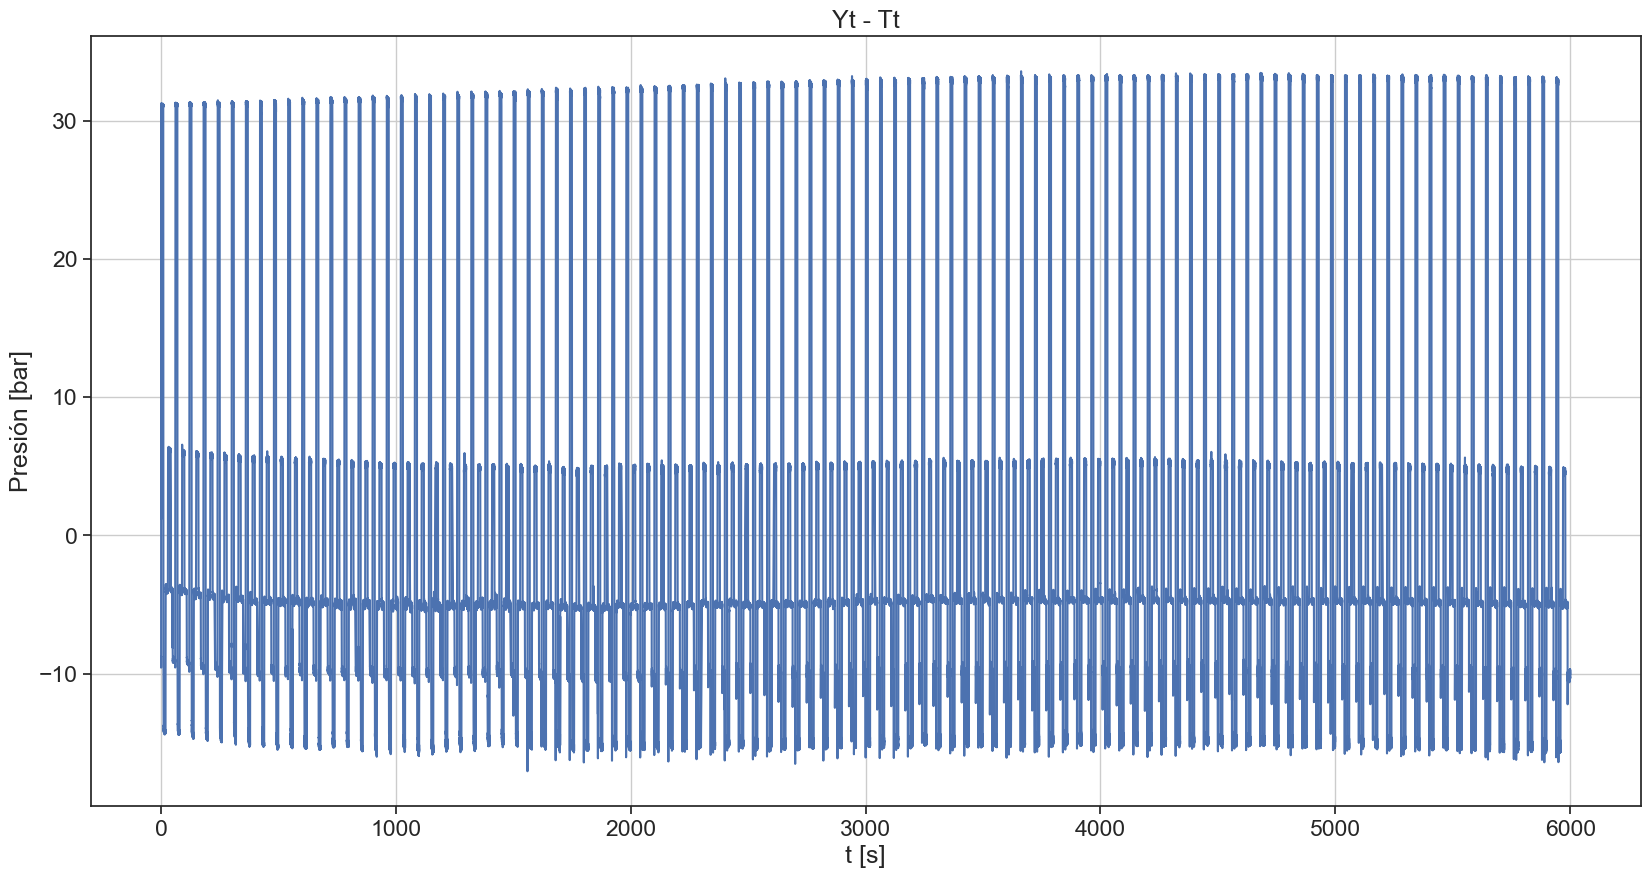

In [15]:
Yt_Tt = x_serie_1d - Tt
print("Media : ",np.mean(Yt_Tt))
print("Varianza : ",np.std(Yt_Tt)**2)
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d, serie_1d-Tt)
ax.set_title("Yt - Tt")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

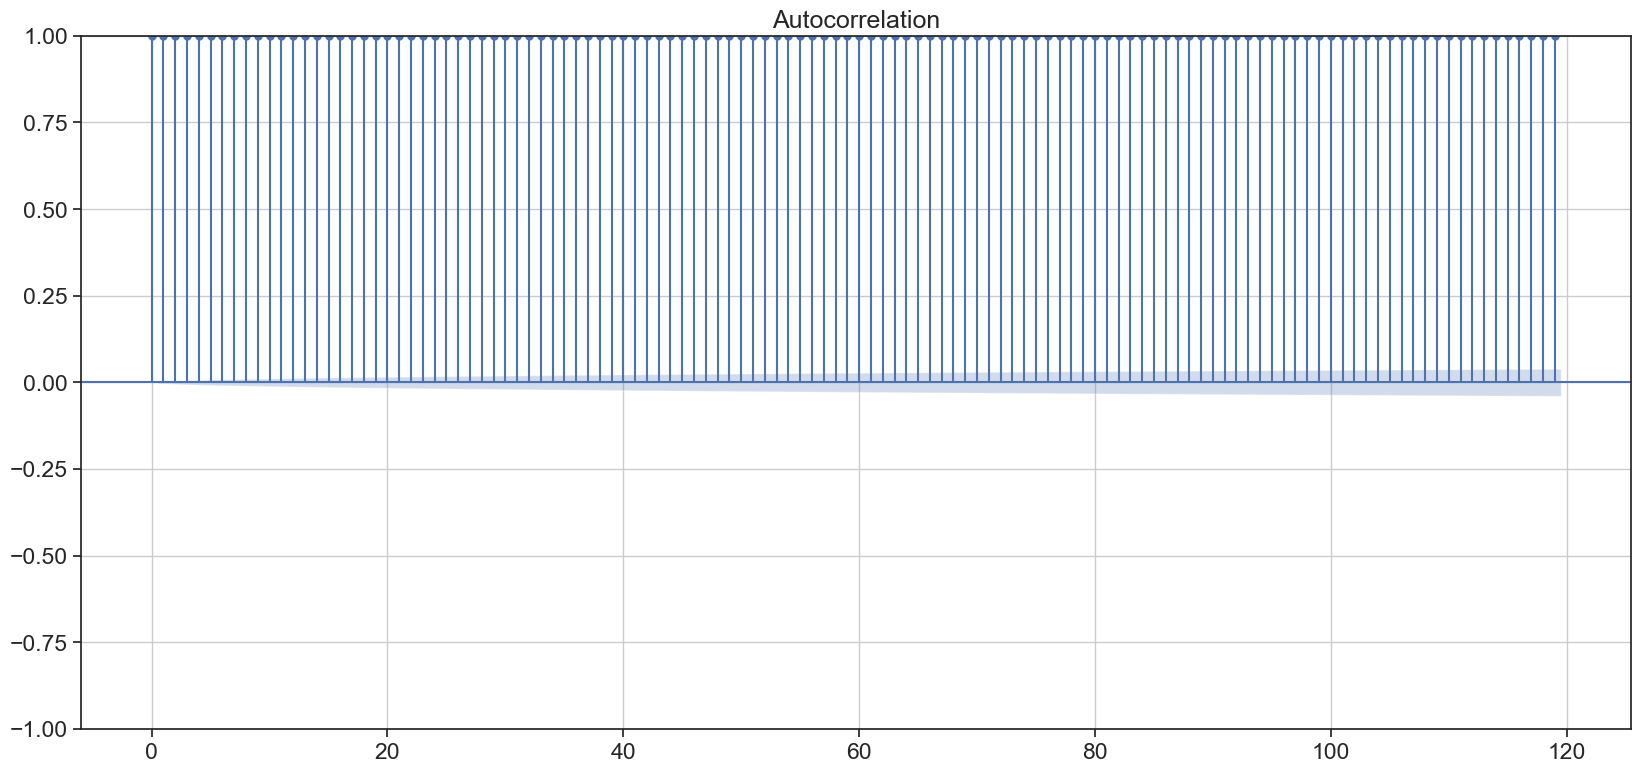

In [16]:
plot_acf(Yt_Tt,lags=np.arange(120))
plt.grid(True)
plt.show()

Aún obviando la componente cíclica, el resultado Yt-Tt tiene media distinta de cero y varianza creciente, es decir, no es estacionario. Dado que tampoco es un proceso blanco, los resultados de cuadrados mínimos **no serían válidos**. Aún así, nos puede servir en la descomposición de las señales. 

Para la componente ciclica, utilizaremos dos enfoques: por un lado fourier y por el otro considerar la componente ciclica como un conjunto de parámetros que se repiten cada T muestras (con T=ciclo).

En este caso, por la construcción del dataset, se conoce que el ciclo es de 60 segundos (6000 muestras). De todos modos, se utilizará análisis espectral para corroborar.

In [17]:
# Componente ciclica 
Ct = np.mean(serie-Tt.reshape(serie.shape),axis=0)

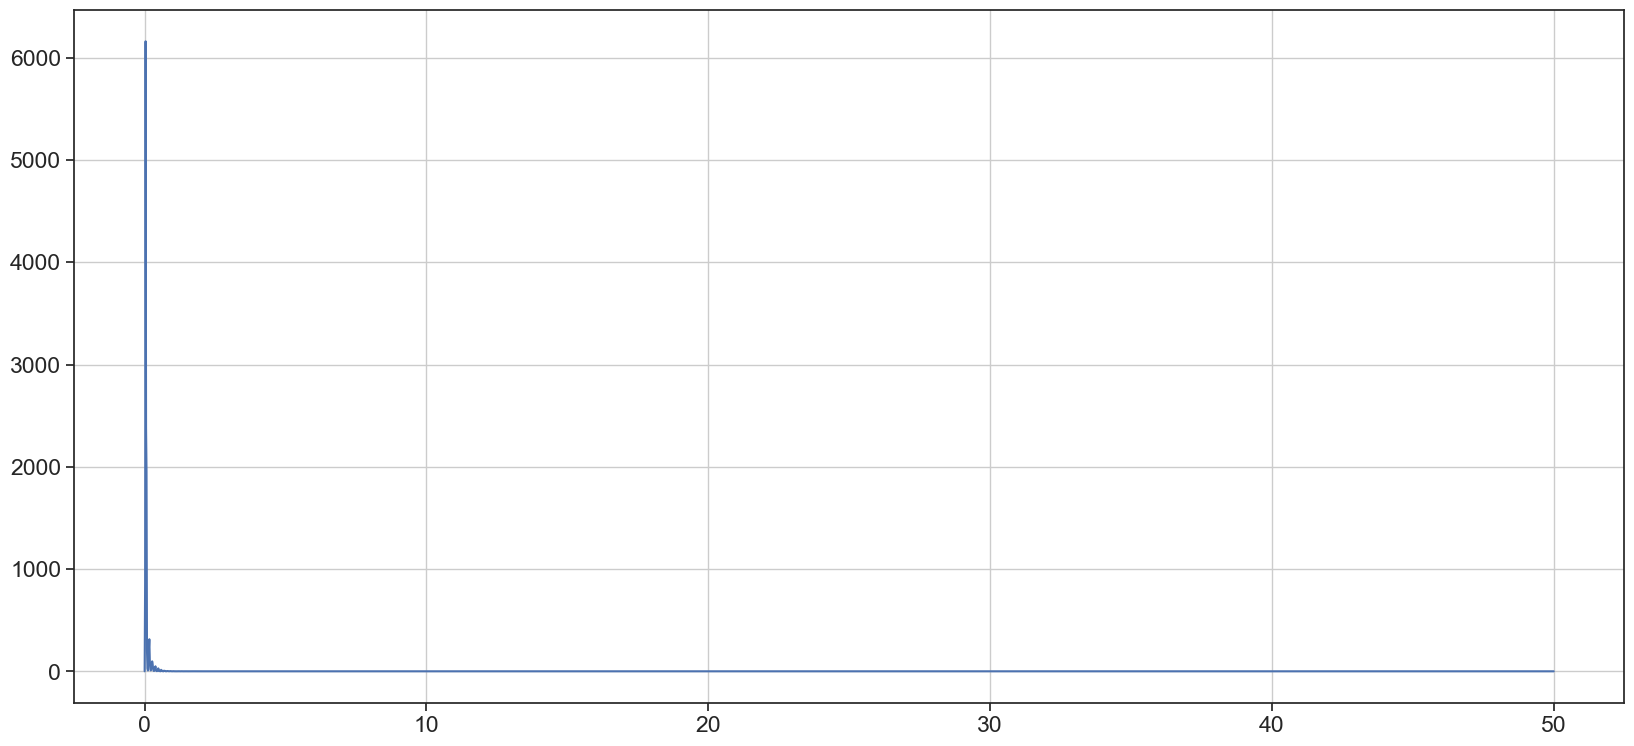

In [18]:
# Calculo periodograma
G, Pyy_den = signal.periodogram(Ct,100)
plt.plot(G, Pyy_den)
plt.grid(True)
plt.show()

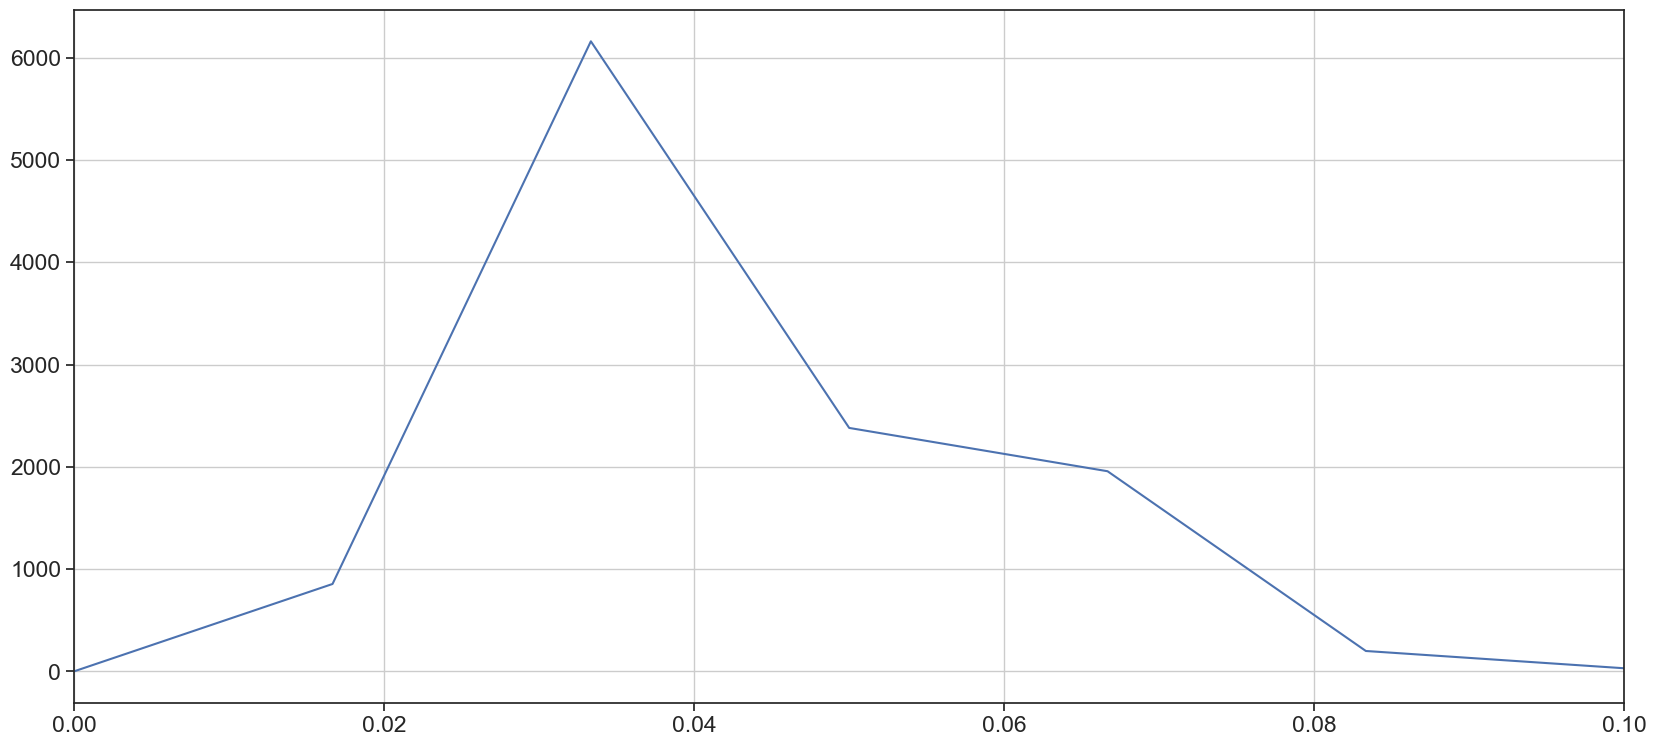

In [39]:
plt.plot(G, Pyy_den)
plt.xlim(0,0.1)
plt.grid(True)
plt.show()

In [20]:
periodo= 1 / (np.argmax(Pyy_den)*50/len(Pyy_den))
periodo

30.009999999999998

Se observa que ademas de la componente de período de 60 segundos (ft=0.16), tenemos sus armónicos superiores (múltiplos de esta frecuencia). 

Un punto a marcar es que el segundo armónico tiene un peso mucho mayor a la fundamental, lo cual resulta inesperado.

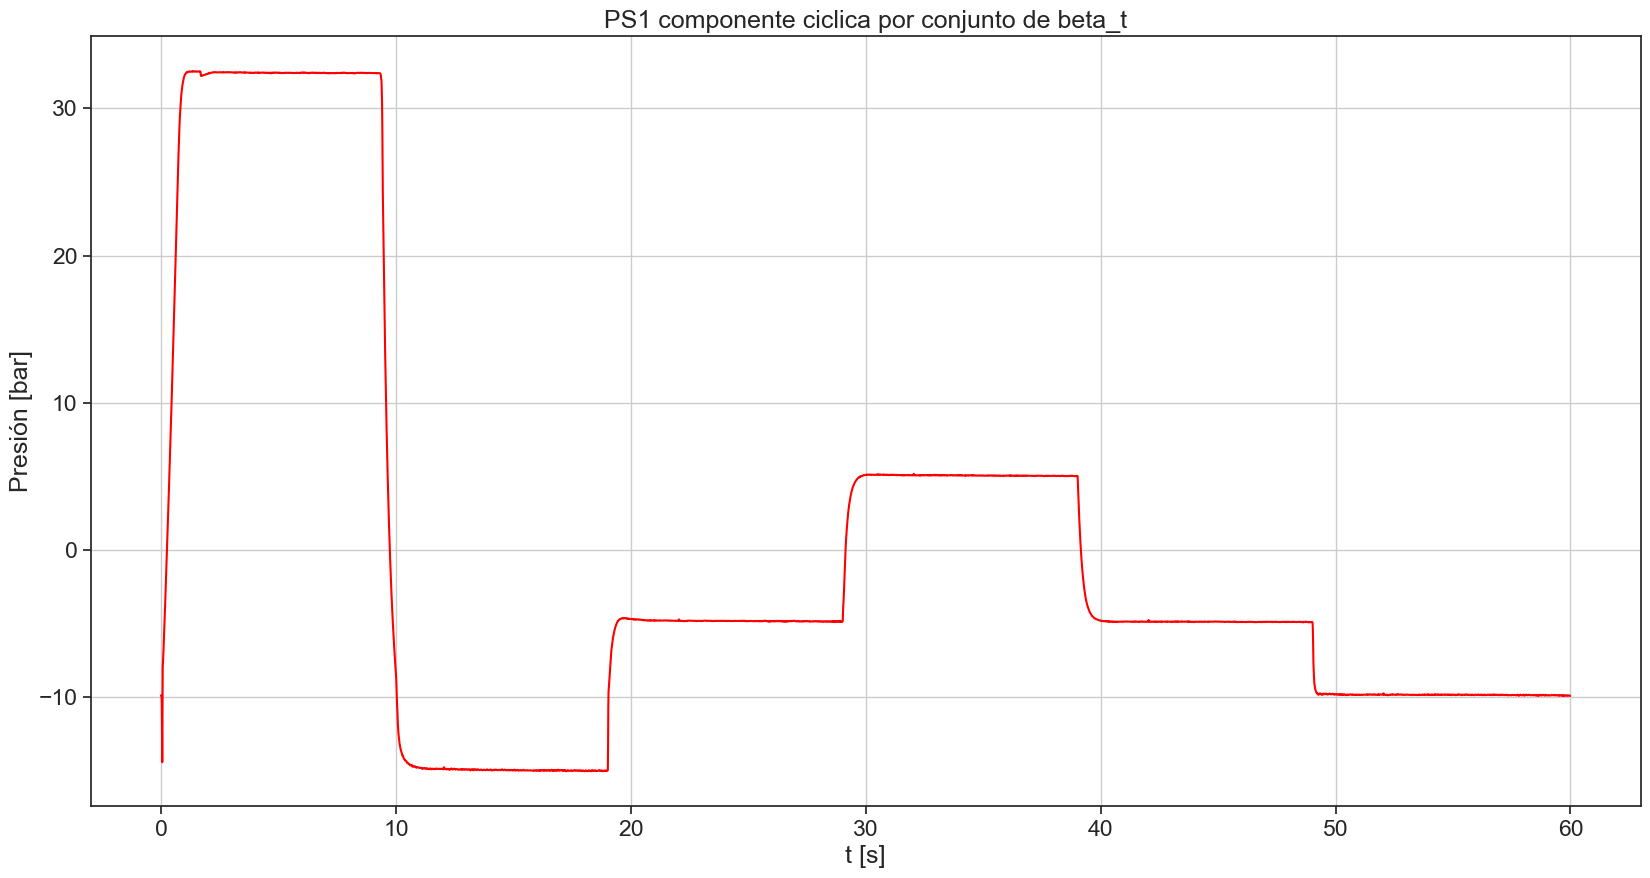

In [21]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie,Ct, color = 'red')
ax.set_title("PS1 componente ciclica por conjunto de beta_t")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

In [22]:
Ct = np.tile(Ct,serie.shape[0])

Para la componente estacional, quitaremos los terminos de tendencia y cíclicos y aproximaremos por un modelo ARIMA

In [23]:
St = serie_1d - Ct - Tt

Media :  3.8350359924758473e-16
Varianza :  0.24791593630606343


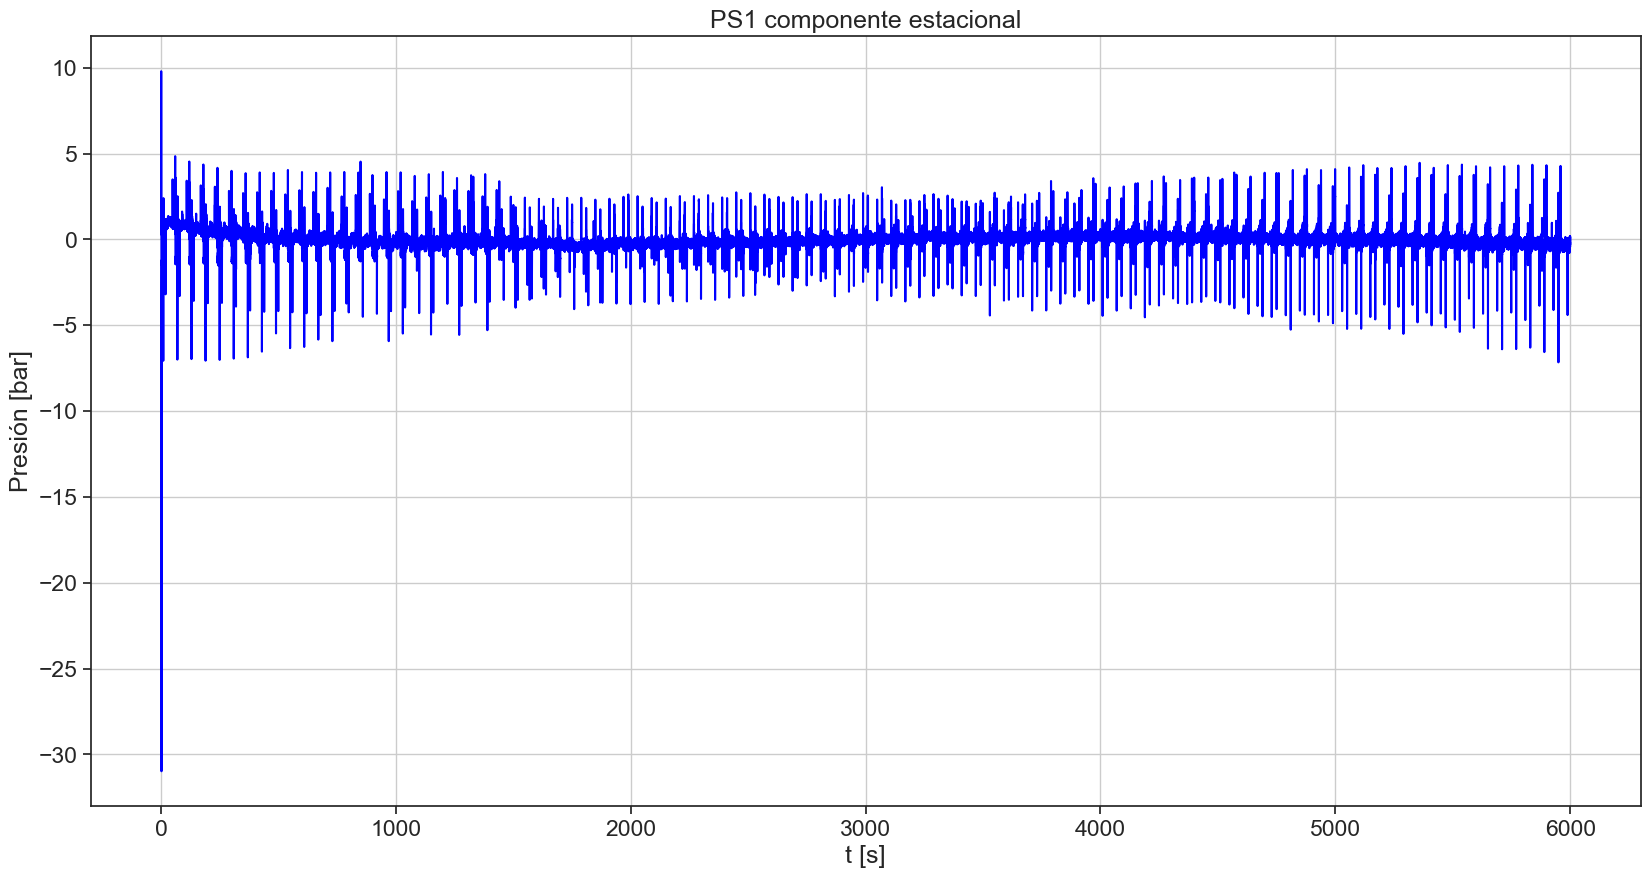

In [24]:
fig, ax = plt.subplots(1,figsize=(20, 10))
print("Media : ",np.mean(St))
print("Varianza : ",np.std(St)**2)
ax.plot(x_serie_1d,St, color = 'blue')
ax.set_title("PS1 componente estacional")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

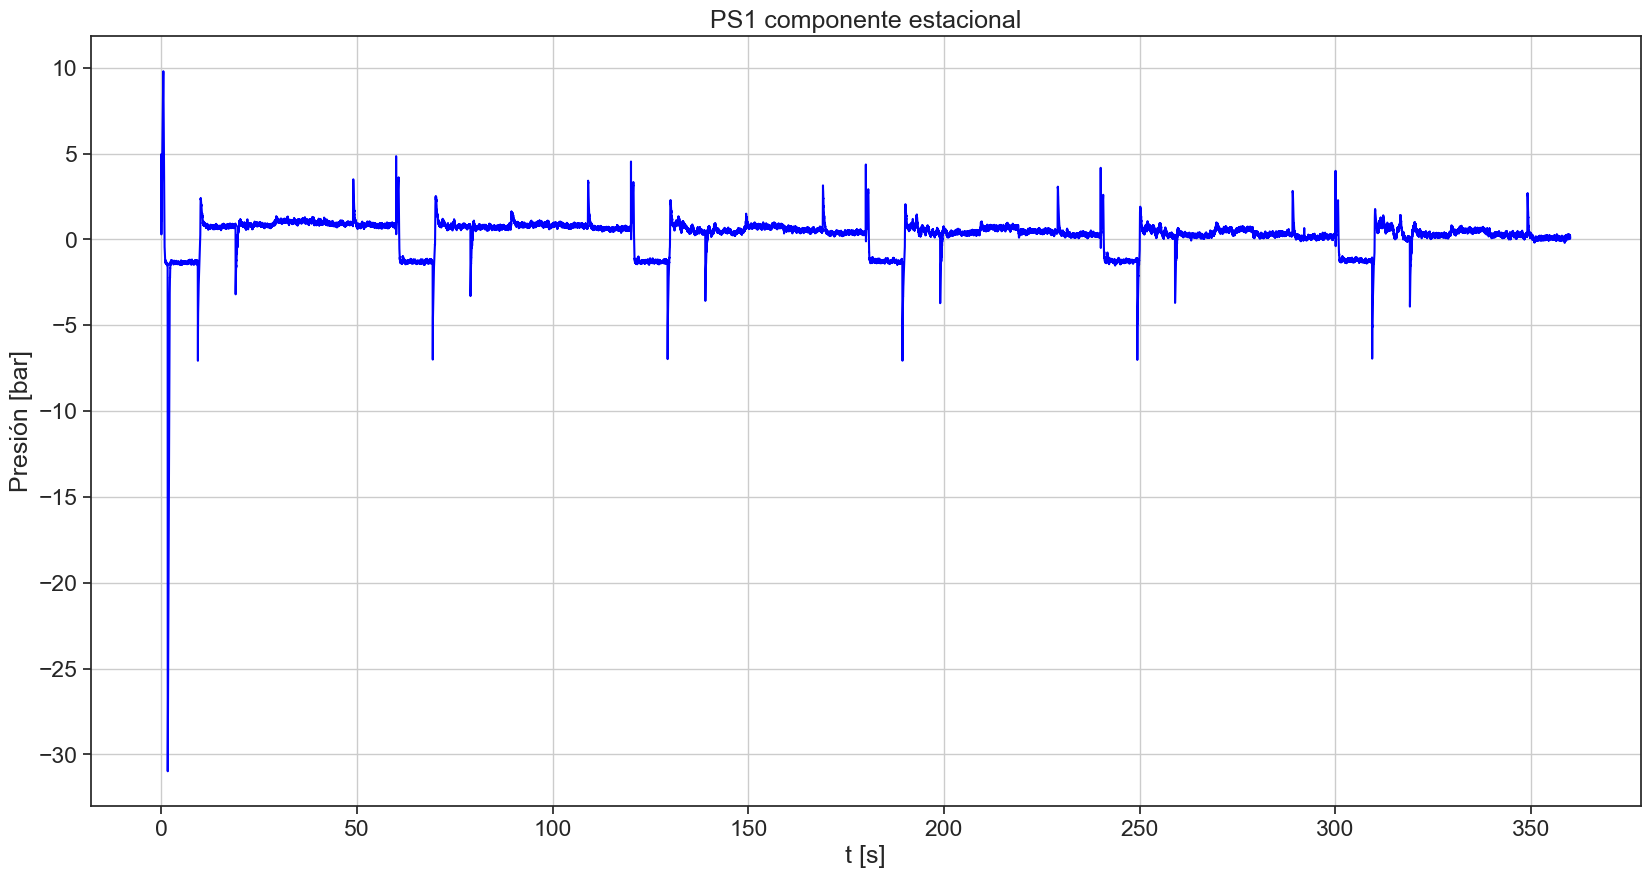

In [25]:
# Vista con mayor detalle
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d[0:36000],St[0:36000],color='blue')
ax.set_title("PS1 componente estacional")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

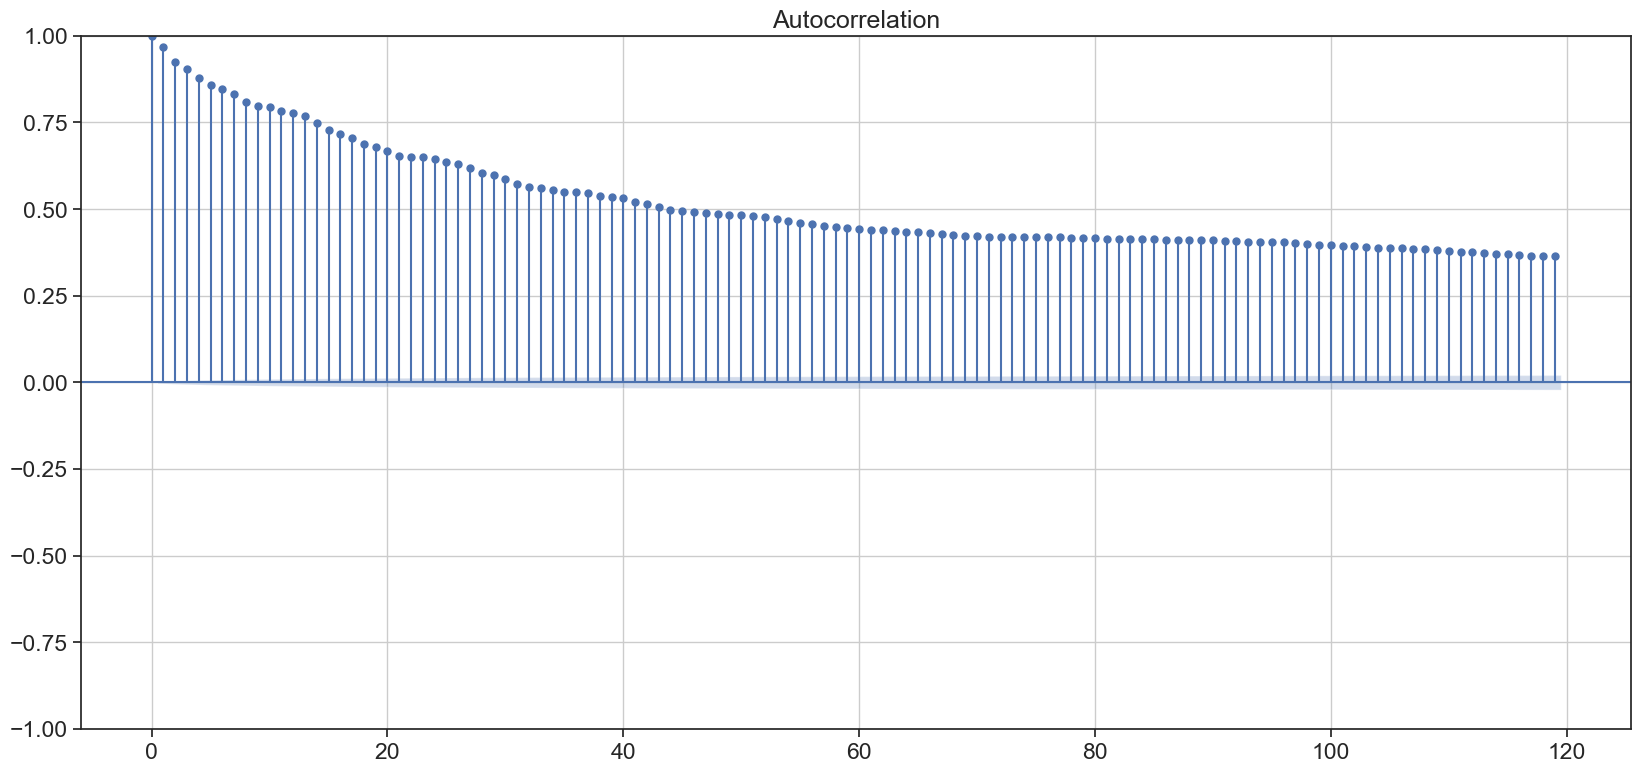

In [26]:
plot_acf(St,lags=np.arange(120))
plt.grid(True)
plt.show()

Ahora el modelo comienza a tener un mejor comportamiento pero aún no es estacionario. De la gráfica en función del tiempo parece haber todavía componentes cíclicas. Se propone aplicar diferenciación en grados crecientes y observar los resultados.

In [27]:
d1_St = list()
for i in range(1, St.shape[0]):
    d1_St.append(St[i] - St[i - 1])
d1_St=np.array(d1_St)

Media :  -2.3435460660106266e-06
Varianza :  0.015360534162710522


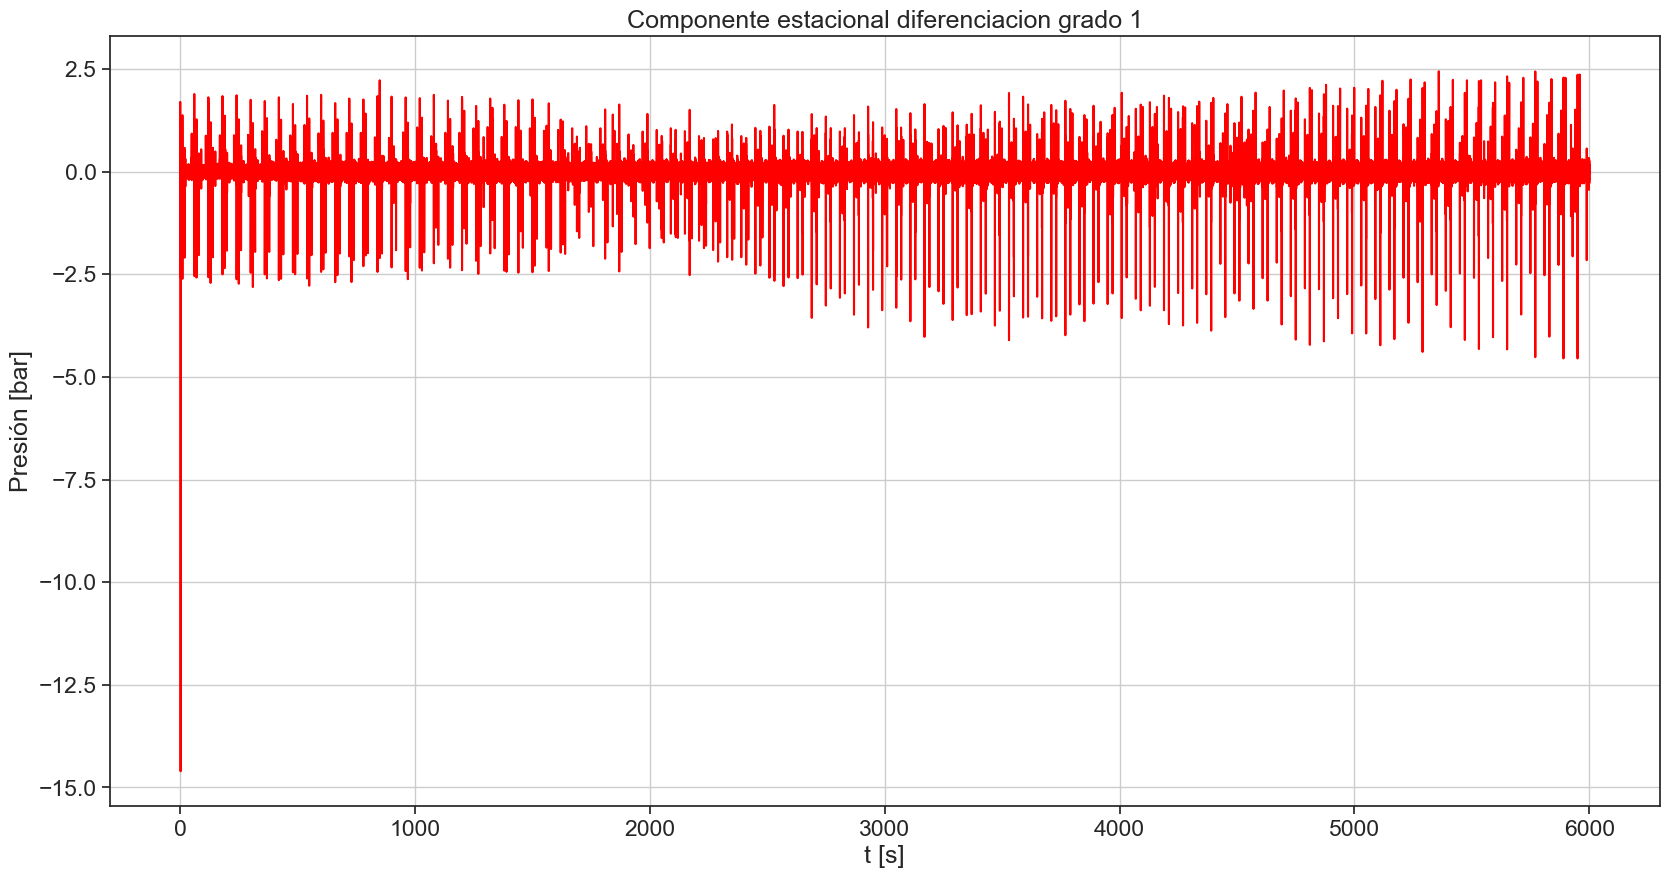

In [28]:
fig, ax = plt.subplots(1,figsize=(20, 10))
print("Media : ",np.mean(d1_St))
print("Varianza : ",np.std(d1_St)**2)
ax.plot(x_serie_1d[1:],d1_St, color = 'red')
ax.set_title("Componente estacional diferenciacion grado 1")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

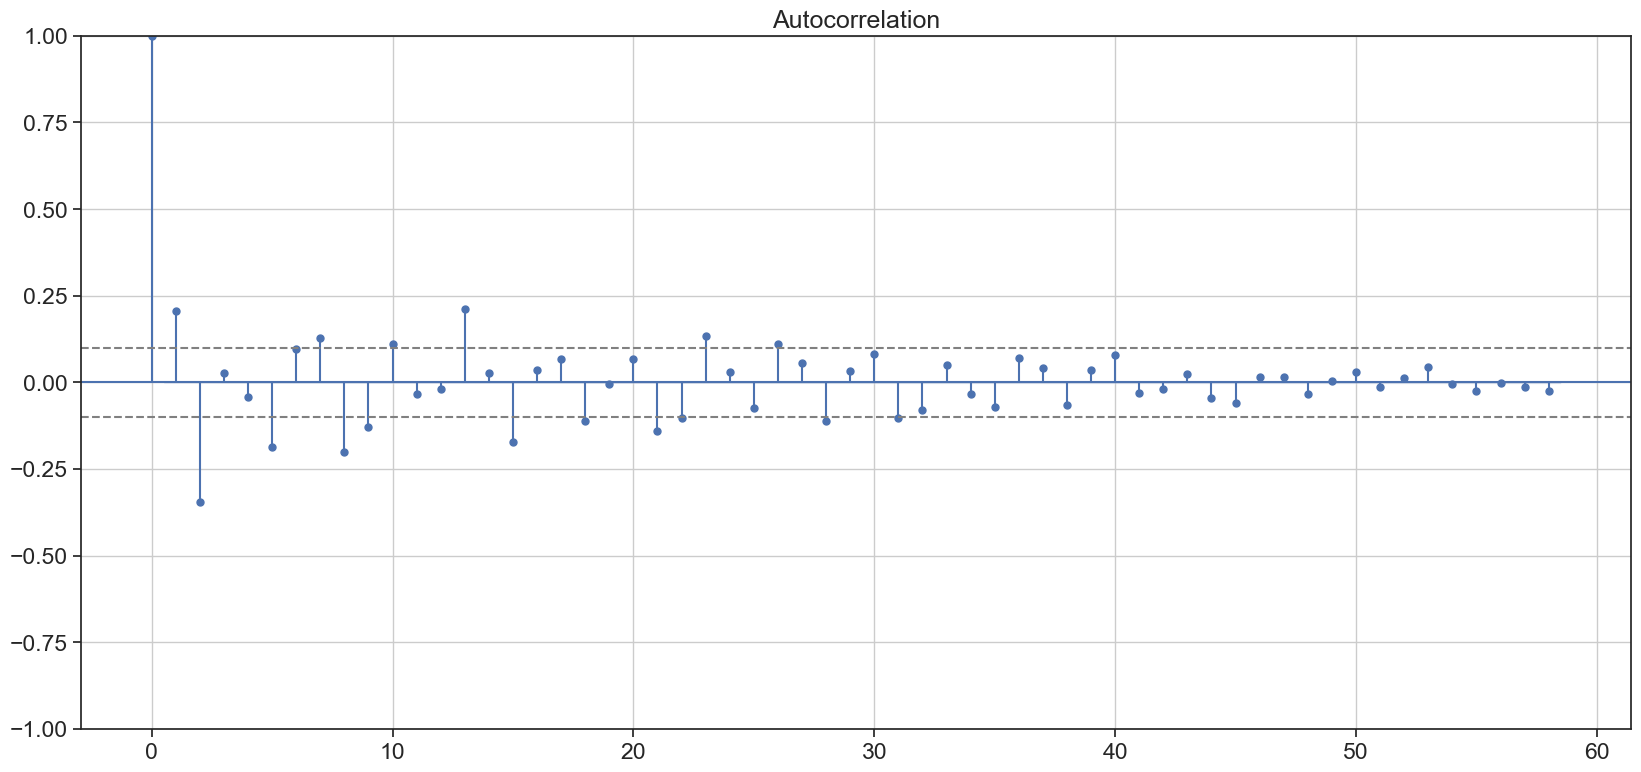

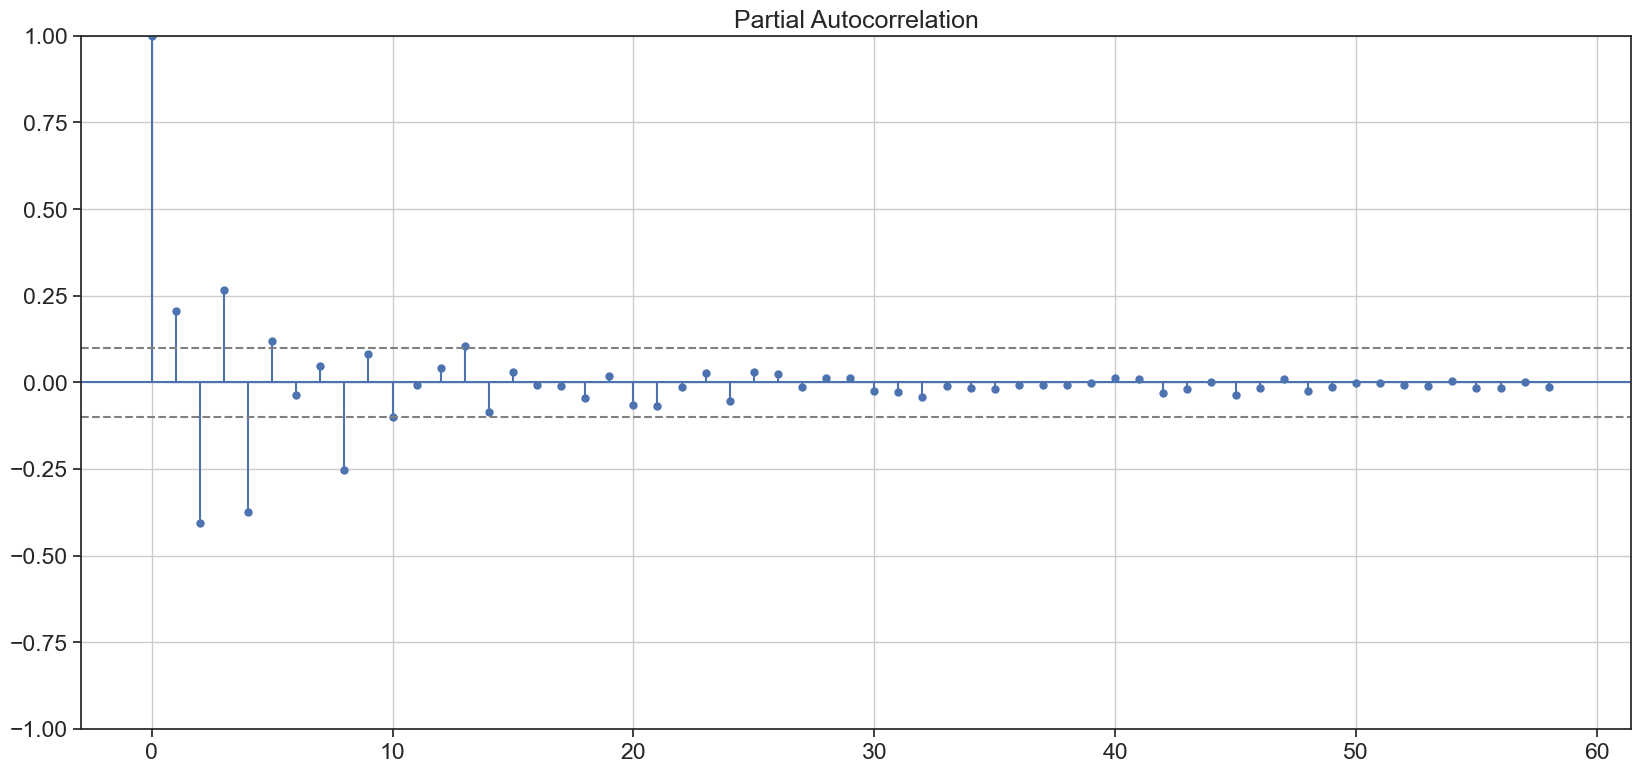

In [29]:
plot_acf(d1_St)
plt.grid(True)
plt.axhline(y=0.1, color='grey', linestyle='dashed')
plt.axhline(y=-0.1, color='grey', linestyle='dashed')
plt.show()
plot_pacf(d1_St,method="ywm")
plt.grid(True)
plt.axhline(y=0.1, color='grey', linestyle='dashed')
plt.axhline(y=-0.1, color='grey', linestyle='dashed')
plt.show()

A primera vista ya se observa que, luego de la diferenciación, la serie podría llegar a ser estacionaria.
A partir de la Autocorrelación proponemos q=2 y de la autocorrelación parcial, p=5. Es decir, proponemos inicialmente un modelo ARIMA(5,1,2)

# ¿Probar con Test DF si tengo "estacionariedad" ?

In [30]:
St_arima = ARIMA(St,order=(5,1,2))
model_fit = St_arima.fit()
print(model_fit.summary())

C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               600000
Model:                 ARIMA(5, 1, 2)   Log Likelihood              555010.894
Date:                Tue, 30 Nov 2021   AIC                       -1110005.787
Time:                        17:11:53   BIC                       -1109915.350
Sample:                             0   HQIC                      -1109980.377
                             - 600000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2846      0.003    -94.834      0.000      -0.291      -0.279
ar.L2         -0.2904      0.001   -525.248      0.000      -0.292      -0.289
ar.L3         -0.0594      0.001    -43.940      0.0

De esta tabla se obtienen los 5 parámetros de AR(p) (ar.L1 a ar.L5)y los dos parámetros de MA(q) (ma.L1 y ma.L2). Notar que los parámetros tienen una disperción muy baja, por lo que fueron cálculados con buena precisión. 

También, al análizar los resultados para el test de Ljung-Box, el p-valor asociado es >0.5 por lo que podemos decir que los residuos estan descorrelacionados

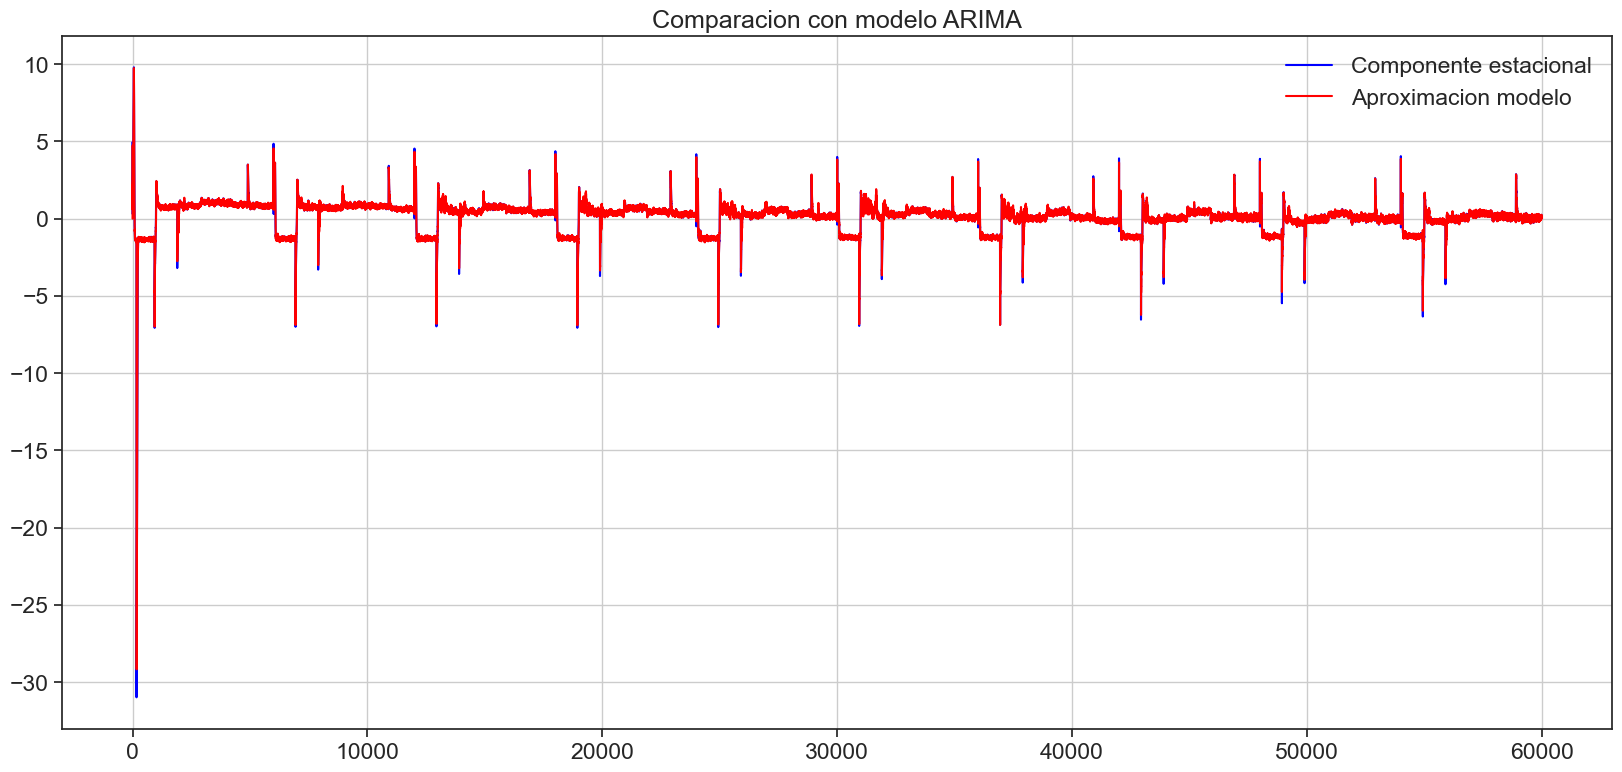

In [31]:
plt.plot(St[0:60000], color='blue', label='Componente estacional')
plt.plot(model_fit.fittedvalues[0:60000], color='red', label="Aproximacion modelo")
plt.grid(True)
plt.legend()
plt.title("Comparacion con modelo ARIMA")
plt.show()

La grafica muesra que el modelo ARIMA sigue con muy buena presición a la serie de tiempo.

Se analizarán ahora los residuos:

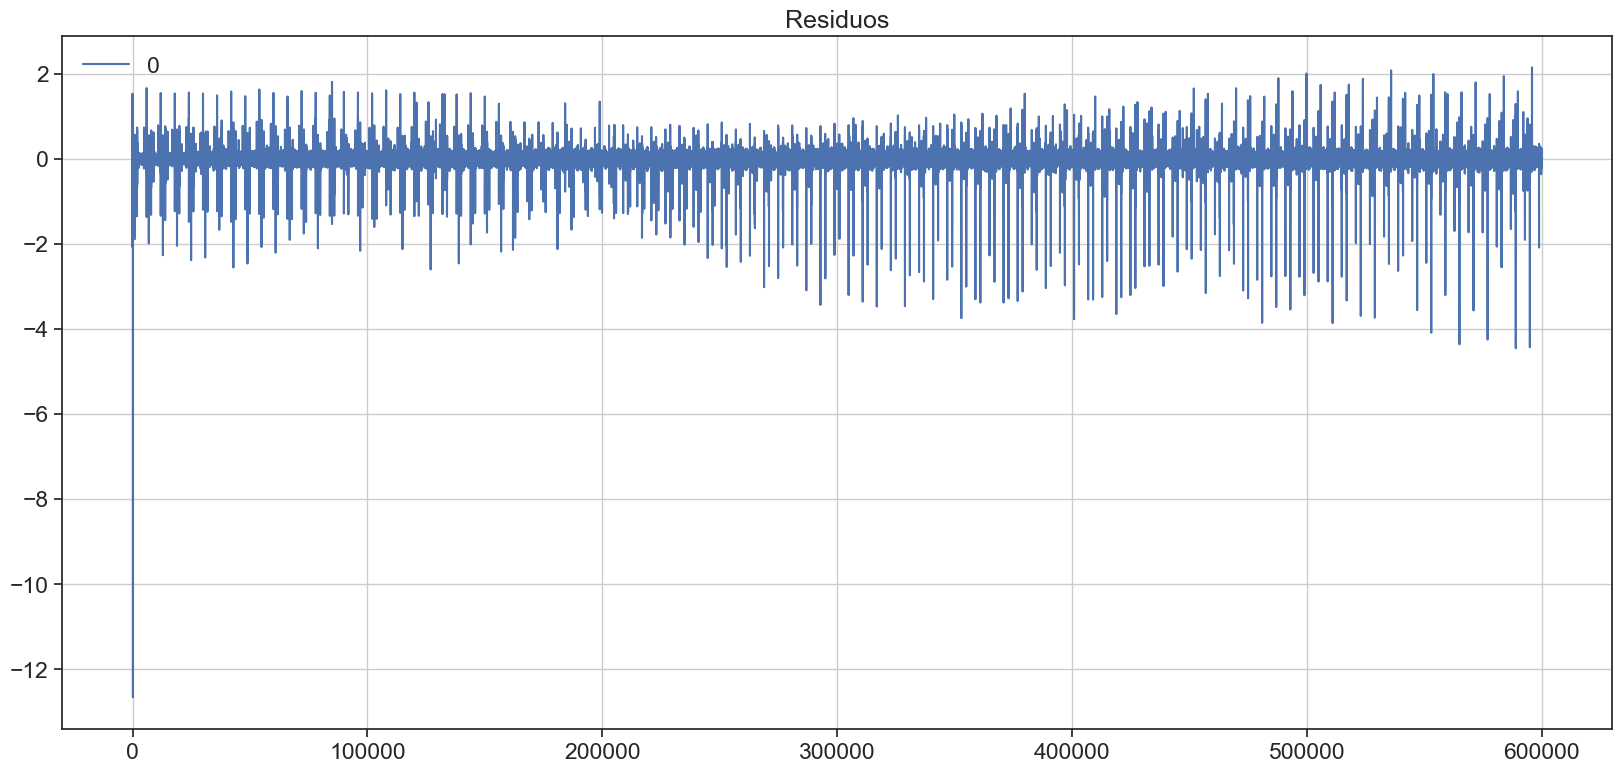

In [32]:
residuals = model_fit.resid
pd_residuals = pd.DataFrame(residuals)
pd_residuals.plot()
plt.grid(True)
plt.title('Residuos')
plt.show()

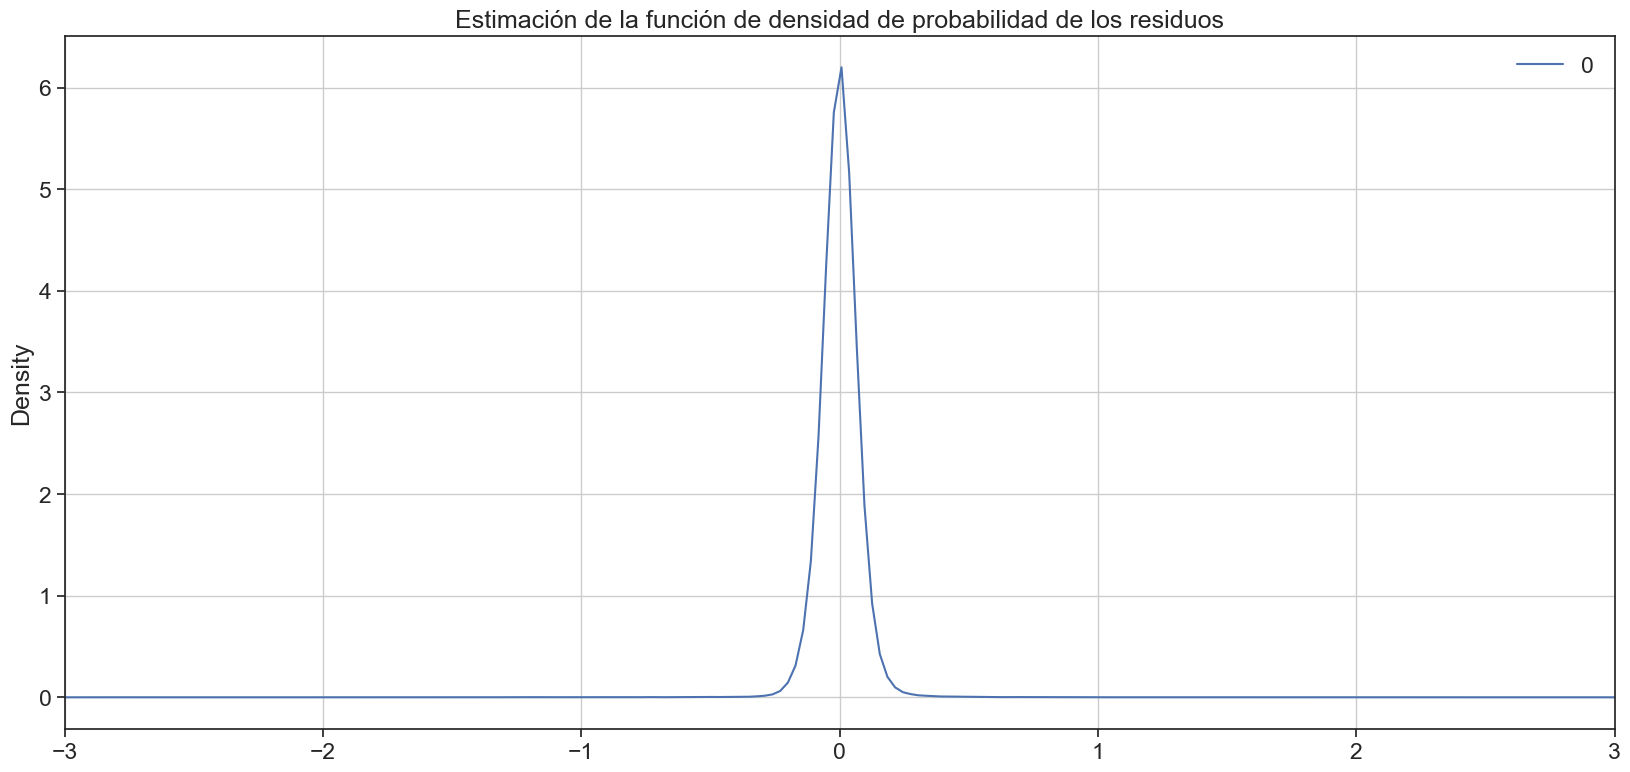

In [33]:
pd_residuals.plot(kind='kde')
plt.grid(True)
plt.title("Estimación de la función de densidad de probabilidad de los residuos")
plt.xlim(-3,3)
plt.show()

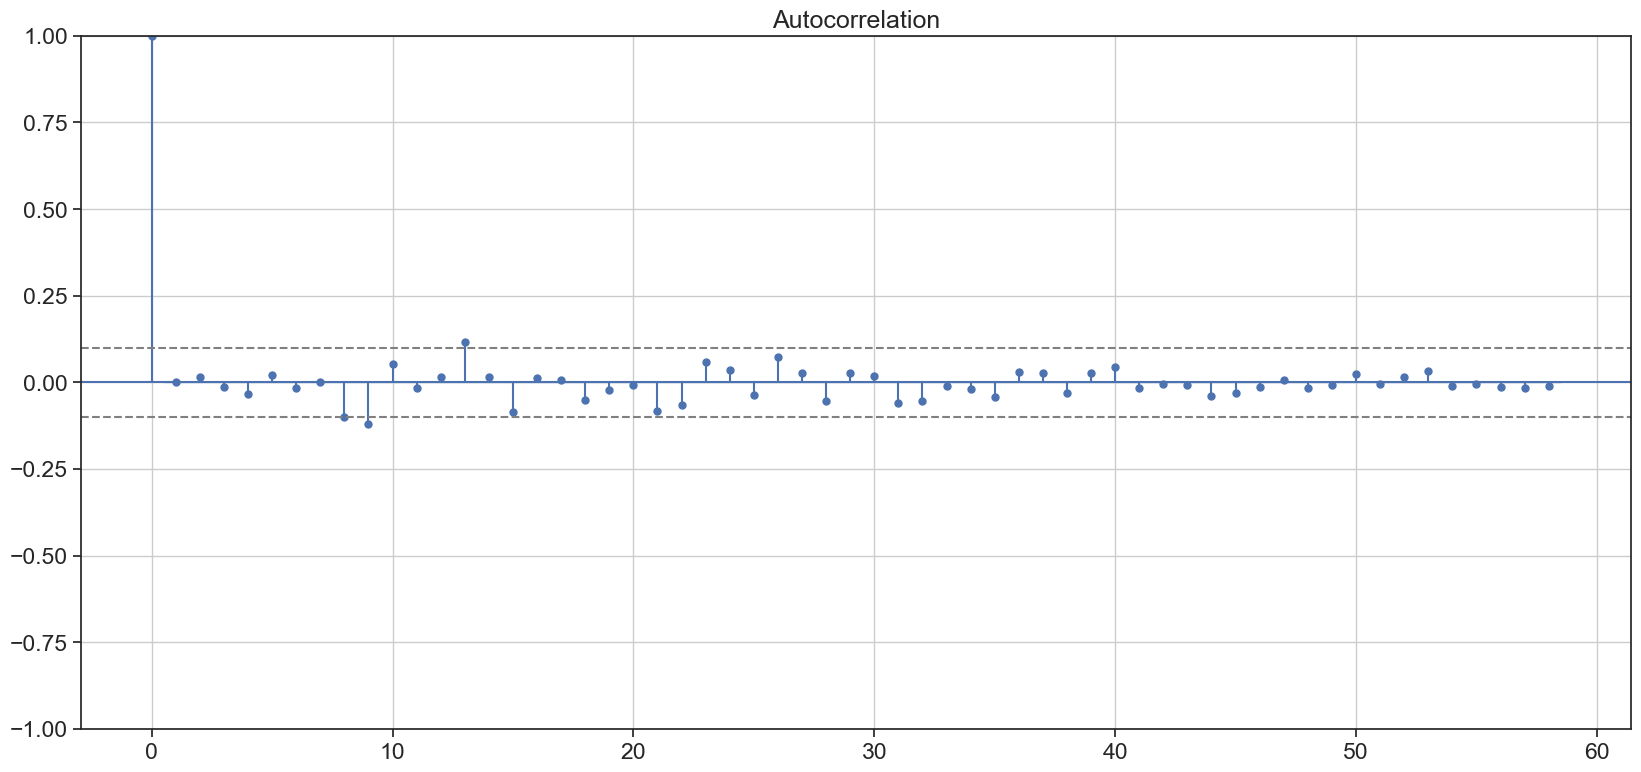

In [34]:
plot_acf(residuals)
plt.grid(True)
plt.axhline(y=0.1, color='grey', linestyle='dashed')
plt.axhline(y=-0.1, color='grey', linestyle='dashed')
plt.show()

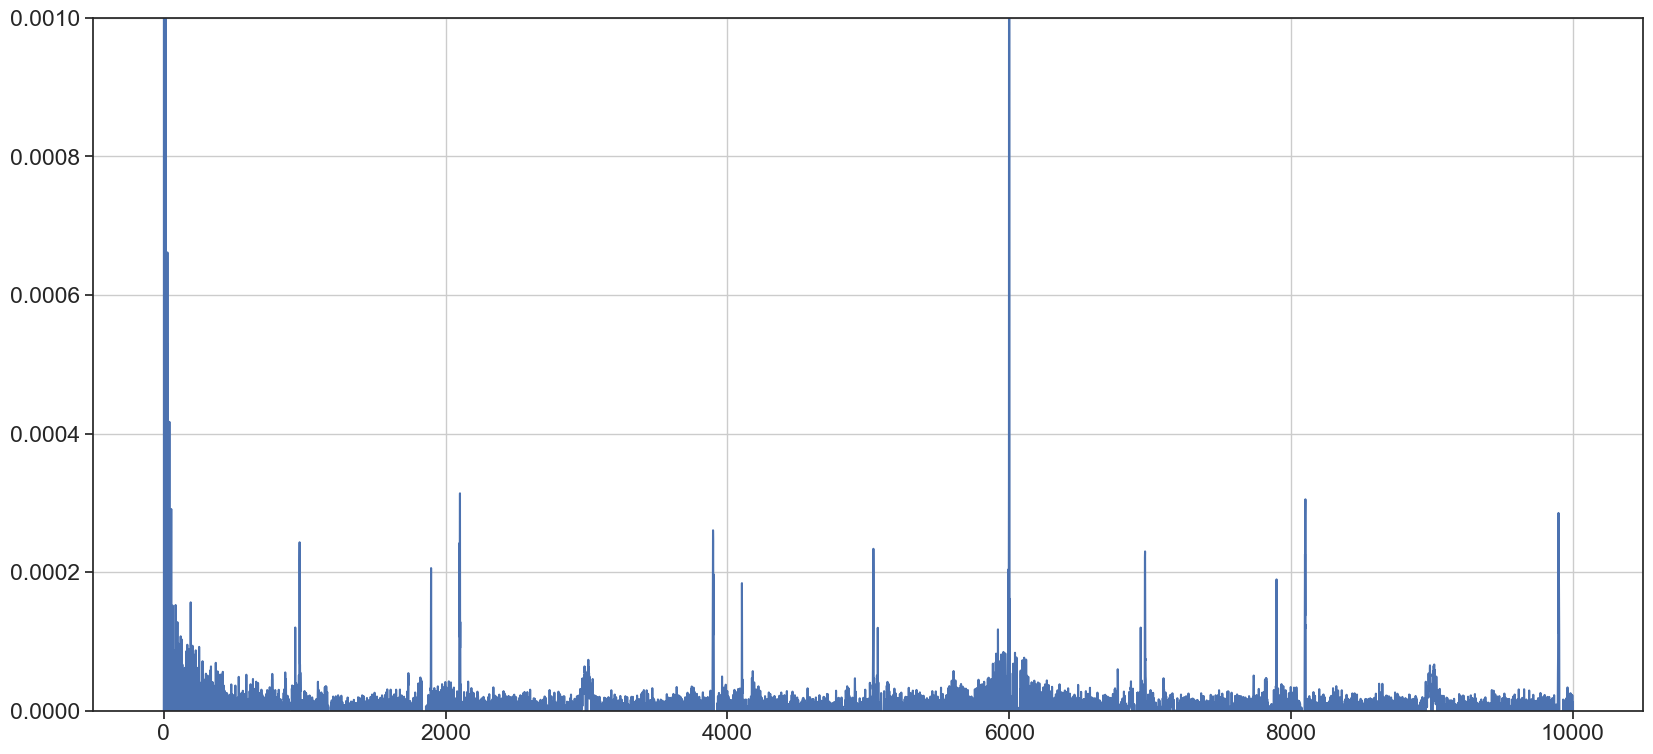

In [52]:
c_k=acovf(residuals,nlag=10000)
plt.plot(c_k)
plt.ylim(0,0.001)
plt.grid(True)
plt.show()

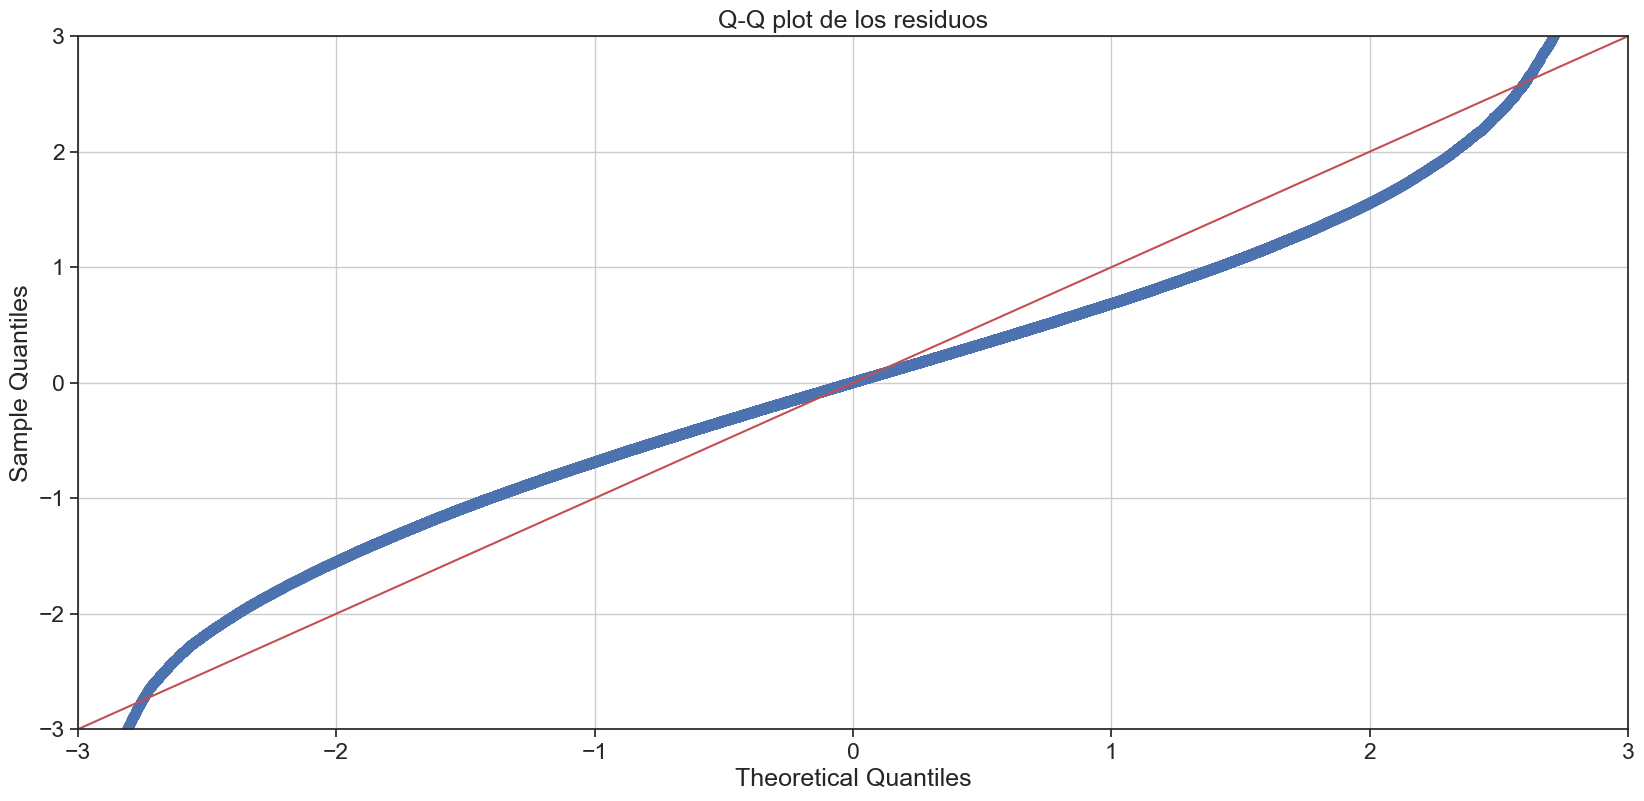

In [35]:
qqplot((residuals-residuals.mean())/residuals.std(), line="45")
plt.title("Q-Q plot de los residuos")
plt.grid(True)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [36]:
print(pd_residuals.describe())

                  0
count  6.000000e+05
mean  -1.432039e-07
std    9.596378e-02
min   -1.266411e+01
25%   -4.315570e-02
50%    6.507098e-04
75%    4.404277e-02
max    2.150621e+00


Entonces, los residuos:
- Tienen media cero y varianza muy pequeña (0.09)
- Parecen estar altamente descorrelacionados
- No siguen una distribución normal, sino que forman una distribución mas "puntiaguda". 

Se concluye que el modelo ARIMA propuesto es apropiado.